In [1]:
import os

import sys
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\src")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN")
sys.path.append("C:\\Users\\User\\PycharmProjects\\GIEBN\\venv")

path = os.getcwd()

curr_path = path.replace('\\', '/')
head_place = curr_path.find('GIEBN')
main_path = curr_path[:head_place]+'GIEBN'
main_path

'c:/Users/User/PycharmProjects/GIEBN'

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.datasets import make_regression

from auxiliary.auxiliary import construct_by_kmeans
from pgmpy.estimators import K2Score
from bamt.networks.discrete_bn import DiscreteBN
from bamt_inherited.networks.discrete import DiscreteBNGI
import shap

from tqdm import tqdm

imagespath = 'C://Users/User/PycharmProjects/GIEBN/experiments/shaplime/images'

In [3]:
data = pd.read_csv("../../datasets/Bike_Sharing_Demand.csv")

n = data.shape[0]
target = "count"
features = ['feel_temp', 'humidity', 'windspeed']
data = data[features+[target]]
n_features = len(features)
data.head(10)

,feel_temp,humidity,windspeed,count
0,14.395,0.81,0.0000,16.0
1,13.635,0.80,0.0000,40.0
2,13.635,0.80,0.0000,32.0
3,14.395,0.75,0.0000,13.0
4,14.395,0.75,0.0000,1.0
5,12.880,0.75,6.0032,1.0
6,13.635,0.80,0.0000,2.0
7,12.880,0.86,0.0000,3.0
8,14.395,0.75,0.0000,8.0
9,17.425,0.76,0.0000,14.0


In [4]:
%run ../common_code.ipynb

In [5]:
data_disc, tfdata = discretize(data, features, icat=None, icont=list(range(n_features)))

In [6]:
for feat in data_disc.columns:
    print(data_disc[feat].value_counts())

feel_temp
2    6049
1    5946
0    5384
Name: count, dtype: int64
humidity
1    6408
2    6075
0    4896
Name: count, dtype: int64
windspeed
0    8655
1    6923
2    1801
Name: count, dtype: int64


In [7]:
model = GradientBoostingRegressor(n_estimators=30,)
#model = LinearRegression()
model.fit(data[features], data[target])

GradientBoostingRegressor(n_estimators=30)

In [8]:
data_errors = data.copy(deep=True)
data_errors["ape_error"] = np.abs((data[target]-model.predict(data[features]))/data[target])
data_errors.drop(columns=[target], inplace=True)
data_errors.head()

,feel_temp,humidity,windspeed,ape_error
0,14.395,0.81,0.0,4.644600
1,13.635,0.80,0.0,1.046492
2,13.635,0.80,0.0,1.558115
3,14.395,0.75,0.0,5.947200
4,14.395,0.75,0.0,89.313595


In [9]:
disc_data, pipeline_data = discretize(data_errors, features+["ape_error"], icat=None, icont=list(range(n_features+1)))
disc_data

,feel_temp,humidity,windspeed,ape_error
0,0,2,0,0
1,0,2,0,0
2,0,2,0,0
3,0,2,0,0
4,0,2,0,2
...,...,...,...,...
17374,0,1,0,0
17375,0,1,0,0
17376,0,1,0,0
17377,0,1,0,0


In [10]:
disc_data['ape_error'].value_counts()

ape_error
0    15717
1     1409
2      253
Name: count, dtype: int64

In [11]:
pipeline_data["cont_features_edges"]

array([array([ 0.       , 18.5094356, 28.4297191, 50.       ]),
       array([0.        , 0.49828807, 0.72412953, 1.        ]),
       array([ 0.        , 11.47543404, 22.67763546, 56.9969    ]),
       array([1.58117724e-05, 1.46962601e+01, 5.94244628e+01, 2.32803792e+02])],
      dtype=object)

In [12]:
pipeline_data["cont_features"]

['feel_temp', 'humidity', 'windspeed', 'ape_error']

In [13]:
q = np.linspace(0, 1, 11)
dicval = {feat: [data_errors[feat].quantile(qu) for qu in q] for feat in pipeline_data["cont_features"]}
#dicval
v = pipeline_data["cont_features_edges"]
for i in [3]:
    v[i] = [v[i][0], dicval[pipeline_data["cont_features"][i]][3], dicval[pipeline_data["cont_features"][i]][7],
            v[i][3]]
pipeline_data["transformer"].steps[0][1].bin_edges_ = v

In [14]:
data__ = pd.DataFrame(pipeline_data["transformer"].transform(data_errors), columns=data_errors.columns)
data__

,feel_temp,humidity,windspeed,ape_error
0,0,2,0,2
1,0,2,0,1
2,0,2,0,2
3,0,2,0,2
4,0,2,0,2
...,...,...,...,...
17374,0,1,0,0
17375,0,1,0,0
17376,0,1,0,0
17377,0,1,0,1


In [15]:
disc_data['ape_error'].value_counts()

ape_error
0    15717
1     1409
2      253
Name: count, dtype: int64

In [18]:
disc_data = data__

In [19]:
current_error = data_errors["ape_error"].sum()/n
current_error

4.959611556509923

In [20]:
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianNetwork
import yodo.yodo
import matplotlib.pyplot as plt
from pgmpy.estimators import PC, BicScore


In [21]:
n_states_map = {feat: disc_data[feat].unique().shape[0] for feat in data_errors.columns}
n_states_map

{'feel_temp': 3, 'humidity': 3, 'windspeed': 3, 'ape_error': 3}

In [22]:
#STORAGE = "C://Users/Дима/PycharmProjects/GIEBN/experiments/pgmpy_yodo_exps/bn_structures"

bn = DiscreteBN()
bn.add_nodes({"types": {feat: "disc" for feat in data_errors.columns}})

blacklist = [("ape_error", x) for x in features]
#bn.add_edges(disc_data, scoring_function=("K2", K2Score))
#bn.fit_parameters(data=disc_data)

In [23]:
bn.add_edges(disc_data, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [24]:
bn.get_info()

,name,node_type,data_type,parents,parents_types
0,humidity,Discrete,disc,[],[]
1,windspeed,Discrete,disc,[humidity],[disc]
2,feel_temp,Discrete,disc,"[humidity, windspeed]","[disc, disc]"
3,ape_error,Discrete,disc,"[feel_temp, humidity]","[disc, disc]"


In [25]:

bn.nodes

[humidity, windspeed, feel_temp, ape_error]

In [26]:
bn.fit_parameters(data=disc_data, n_jobs=1)

In [27]:
pgmpy_bn = BayesianNetwork([list(e) for e in bn.edges])
cpds = collect_all_cpds(bn.get_info(), bn.distributions, n_states_map)
for e in cpds:
    if len(e.variables) == 1: # либо узел без родителей, либо изолированный узел
        feat = e.variables[0]
        if not any([(feat in edge) for edge in bn.edges]):
            continue
    pgmpy_bn.add_cpds(e)

<Figure size 640x480 with 0 Axes>

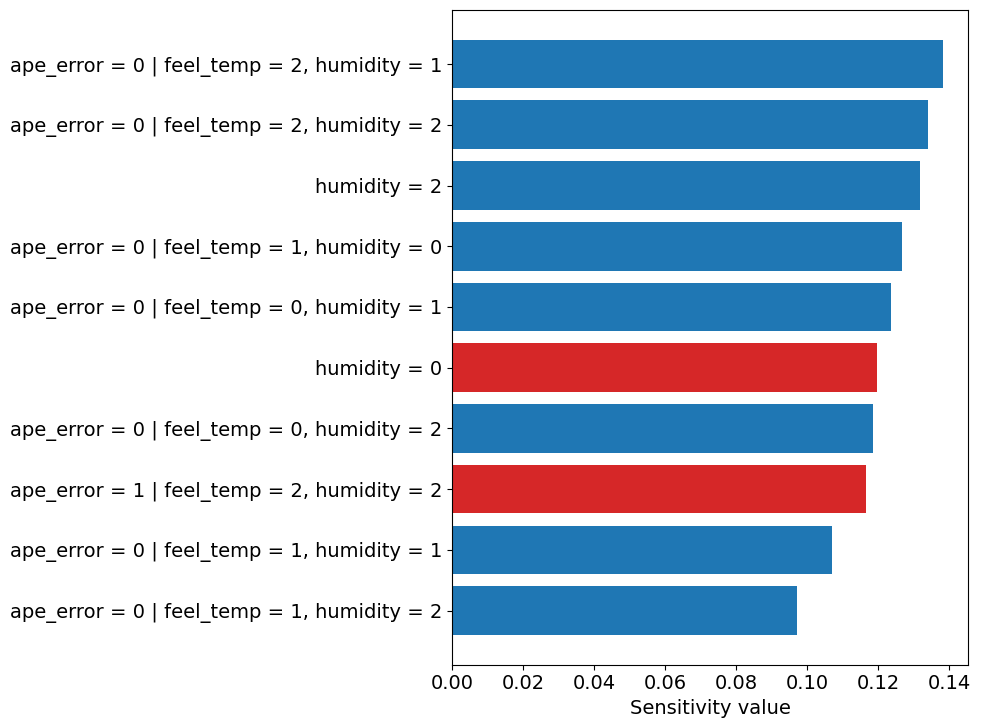

In [28]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'ape_error': 0}, nbars=10)

<Figure size 640x480 with 0 Axes>

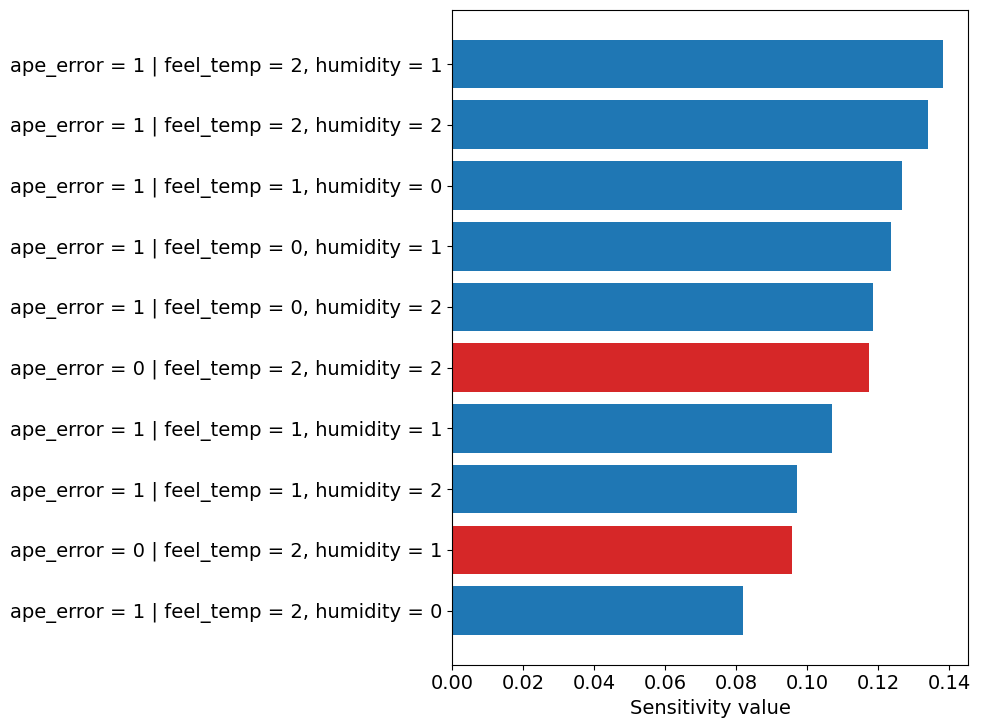

In [29]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'ape_error': 1}, nbars=10)

<Figure size 640x480 with 0 Axes>

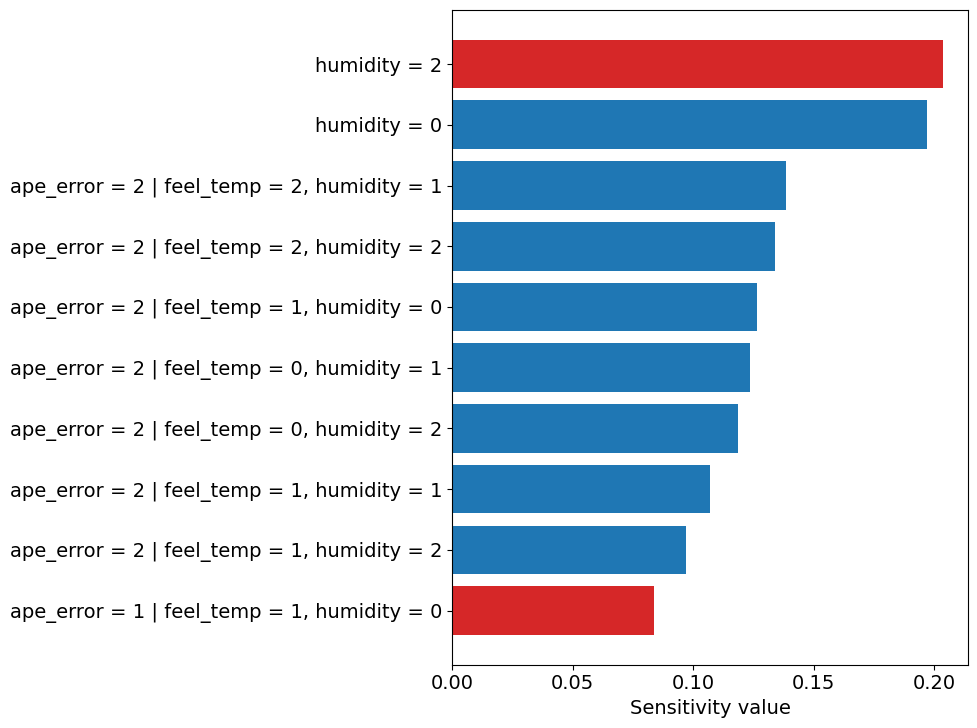

In [30]:
plt.figure()
yodo.plot(pgmpy_bn, probability={'ape_error': 2}, nbars=10)

трактуем так: вероятность того, что ошибка регрессии будет высокой, наиболее чувствительна к изменению параметра, отвечающего за условную вероятность ошибки быть высокой при условии высокого УФ-индекса (здесь 1 маскимальный) и среднего давления

In [31]:
current_error

4.959611556509923

In [32]:
from copy import copy
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as mape

In [33]:
def inconfidence_score(y_true, y_pred):
    return np.mean((1-y_pred)*y_true + y_pred*(1-y_true))

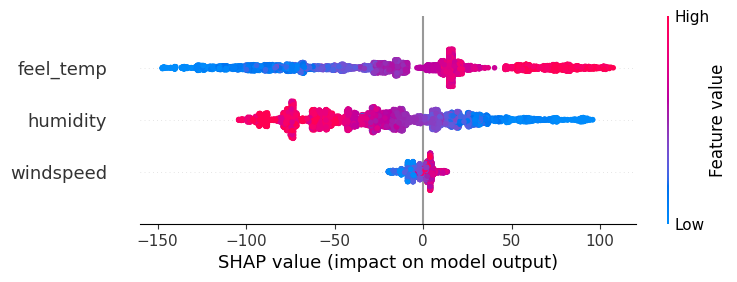

In [34]:
explainer = shap.Explainer(model)
shap_values = explainer(data.reset_index()[disc_data['ape_error']==2][features])
shap.plots.beeswarm(shap_values)
# смотрим на наблюдения с высокой ошибкой -- по ним самый влиятельный фактор такой-то, он чаще приводит к непопаданию в значение

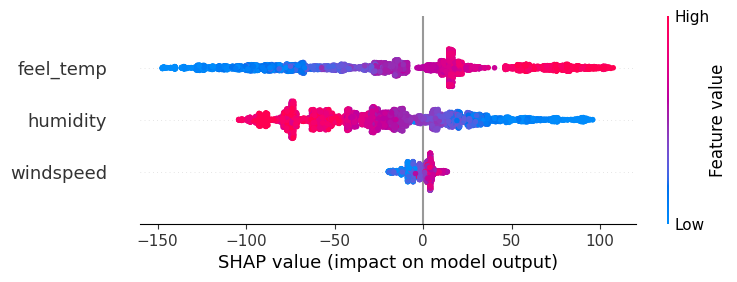

In [35]:
explainer = shap.Explainer(model)
shap_values = explainer(data.reset_index()[disc_data['ape_error']==2][features])
shap.plots.beeswarm(shap_values)
# смотрим на наблюдения с высокой ошибкой -- по ним самый влиятельный фактор такой-то, он чаще приводит к непопаданию в значение

In [36]:
disc_data.shape, data.shape

((17379, 4), (17379, 4))

In [50]:
#dfeat = ["length", "shell_weight"]
#dcat = [2, 1]
dfeat = ['feel_temp', 'humidity']
dcat = [1, 2]

dfeatshap = ['feel_temp', 'humidity']
dcatshap = [0, 2]
#[feel_temp_2, humidity_0, humidity_2, windspeed_0]
dfeatbn = ['feel_temp', 'humidity', 'humidity', 'windspeed']

dcatbn = [2, 0, 2, 0]

d_dict={
    'yodo': [['feel_temp', 'humidity'], [1, 2]],
    'bn': [['feel_temp', 'humidity', 'humidity', 'windspeed'], [2, 0, 2, 0]],
    'shap': [['feel_temp', 'humidity'], [0, 2]]
}

bn = n


In [36]:
data.shape

(17379, 4)

In [51]:
np.random.seed(42)

stats_res = bootstrap_sampling(data, d_dict, bn,
                                    [mape, 
                                    r2_score], trials=50,alpha=0.9, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='regr',
                                    incl_test=True,
                                    test_size=0.25,
                                    stratify_tts=False)

100%|██████████| 50/50 [01:27<00:00,  1.76s/it]


In [52]:
stats_res['avg_n_dropped']

{'yodo': 925.68, 'bn': 1490.94, 'shap': 986.36, 'init': -1, 'random': -1}

In [53]:
{k: v/n for k, v in stats_res['avg_n_dropped'].items()}

{'yodo': 0.0532642844812705,
 'bn': 0.08578974624546867,
 'shap': 0.05675585476724783,
 'init': -5.754071005236205e-05,
 'random': -5.754071005236205e-05}

In [57]:
def plot_scores(metrics, labels, graph_label, k):
    for name in metrics.keys():
        sns.histplot(metrics[name][k], label=names_mapping[name], bins=25)
        print(f'name: {name}', sum(metrics[name][k])/len(metrics[name][k]))
    plt.legend()
    plt.xlabel(graph_label)

names_mapping = {k:v for k, v in
                        zip(['init', 'yodo', 'bn', 'shap', 'random'],
                        ["Before elimination",
                          "YODO",
                          "gradation BN",
                          "SHAP",
                          "random"
                          ])}

name: yodo 5.194128133696472
name: bn 5.369910857924591
name: shap 5.205410102728947
name: init 4.935202044682761
name: random 4.929075459715501
name: yodo 0.29508058223346156
name: bn 0.2826322350296829
name: shap 0.29414310864147664
name: init 0.2992581018579721
name: random 0.2999449586270406


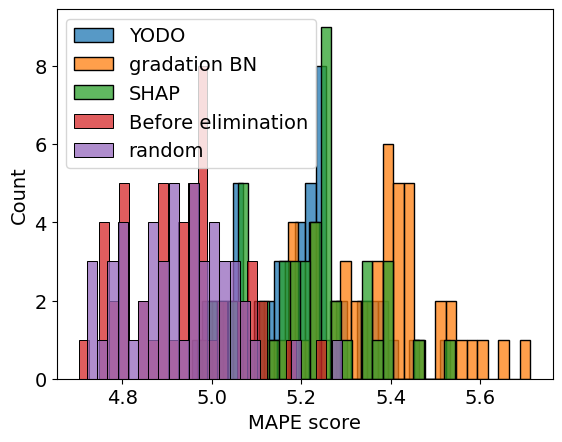

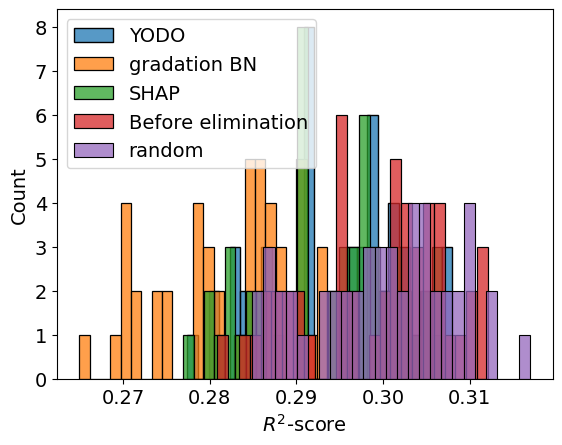

In [58]:
for k, label in enumerate(['MAPE score', '$R^2$-score']):
    plt.figure()
    plot_scores(stats_res['metrics'], ["Before elimination",
                          "YODO",
                          "gradation BN",
                          "SHAP",
                          "random"
                          ], label, k)

name: yodo 4.976261836054145
name: bn 4.9702453278599705
name: shap 4.9695284977654595
name: init 4.992702184999711
name: random 4.992971583667178
name: yodo 0.28547565743435577
name: bn 0.28589326561070827
name: shap 0.28565428921348646
name: init 0.28517306839735473
name: random 0.2851430710230385


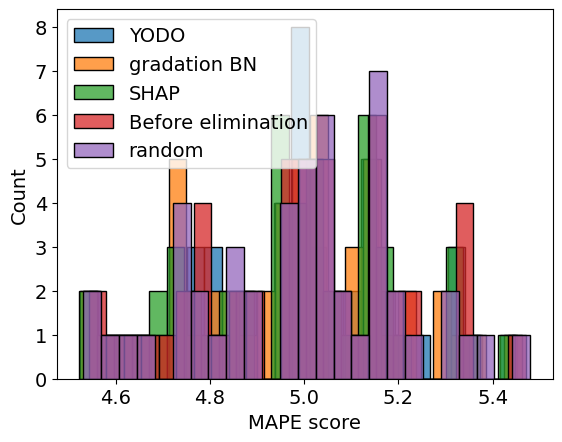

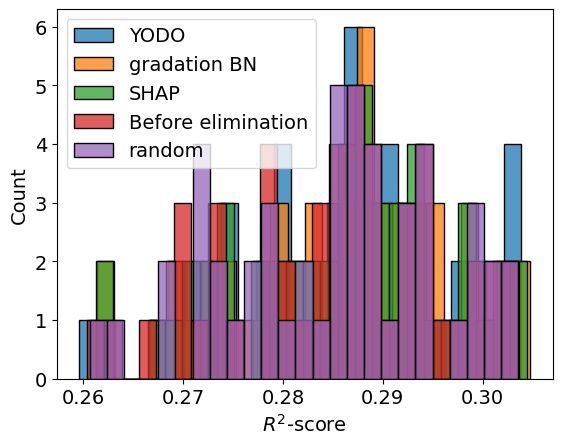

In [59]:

for k, label in enumerate(['MAPE score', '$R^2$-score']):
    plt.figure()
    plot_scores(stats_res['metrics_test'], ["Before elimination",
                          "YODO",
                          "gradation BN",
                          "SHAP",
                          "random"
                          ], label, k)

In [42]:
# Среднее улучшение скоров в процентах
improve = [-sum((a-b)/b for a, b in zip(y[0], stats_res['metrics']['init'][0]))/500*100 for y in stats_res['metrics'].values()]
improve

[3.100611743313024,
 5.6741641314663935,
 3.3809578669398084,
 -0.0,
 0.022514484504763014]

In [ ]:
percentage_changes = {a: list() for a in stats_res['metrics'].keys()}

mean_differences = {a: list() for a in stats_res['metrics'].keys()}

percentage_changes_test = {a: list() for a in stats_res['metrics'].keys()}

mean_differences_test = {a: list() for a in stats_res['metrics'].keys()}

mean_differences2 = list()
alphas = np.linspace(0, 1, 11)
for a in alphas[:-1]:
    np.random.seed(42)
    metrics_info_all = bootstrap_sampling(data, d_dict, bn,
                                    [inconfidence_score, 
                                    log_loss,
                                    roc_auc_score], trials=50,alpha=a, incl_random_removal=True,
                                    drop_mode='metric',
                                    mode='classif',
                                    incl_test=True,
                                    test_size=0.25)
    
    metrics_info, metrics_info_test = metrics_info_all['metrics'], metrics_info_all['metrics_test']
    if a == 0:
        print(_)
        
    for name in stats_res['metrics'].keys():
        x, y = np.array(metrics_info['init'][0]), np.array(metrics_info[name][0])
        mean_differences[name].append((x-y).mean())

        percentage_changes[name].append((-(y-x)/x).mean()*100)

        x, y = np.array(metrics_info_test['init'][0]), np.array(metrics_info_test[name][0])
        mean_differences_test[name].append((x-y).mean())

        percentage_changes_test[name].append((-(y-x)/x).mean()*100)

    

for name in stats_res['metrics'].keys():
    mean_differences[name].append(0)
    percentage_changes[name].append(0)
    mean_differences_test[name].append(0)
    percentage_changes_test[name].append(0)


100%|██████████| 250/250 [06:15<00:00,  1.50s/it]


[3.100611743313024, 5.6741641314663935, 3.3809578669398084, -0.0, 0.022514484504763014]


100%|██████████| 250/250 [08:10<00:00,  1.96s/it]


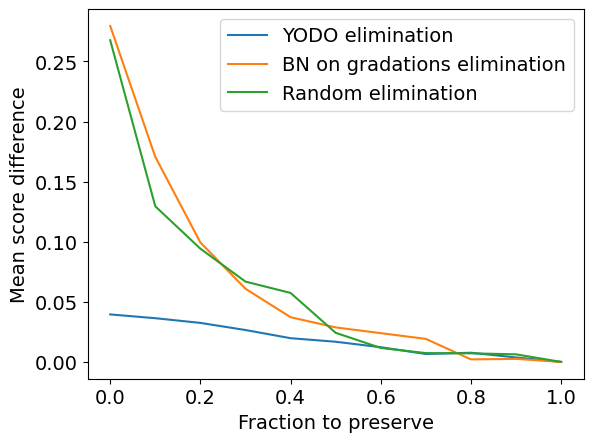

In [45]:
plt.plot(alphas, mean_differences['yodo'], label='YODO elimination')
plt.plot(alphas, mean_differences['bn'], label='BN on gradations elimination')
plt.plot(alphas, mean_differences['random'], label='Random elimination')
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean score difference")
plt.legend()

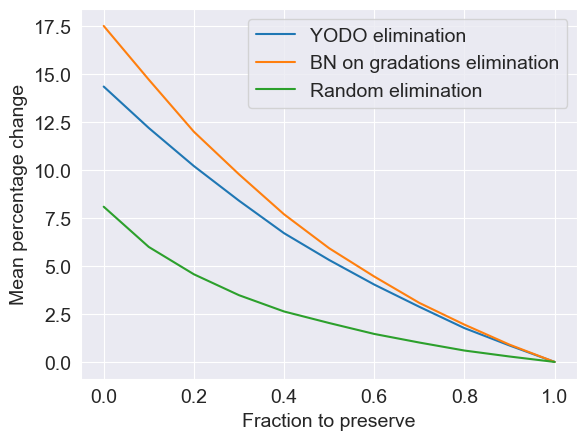

In [48]:
plt.plot(alphas, percentage_changes['yodo'], label='YODO elimination')
plt.plot(alphas, percentage_changes['bn'], label='BN on gradations elimination')
plt.plot(alphas, percentage_changes['random'], label='Random elimination')
plt.xlabel("Fraction to preserve")
plt.ylabel("Mean percentage change")
plt.legend()

In [49]:
from scipy.stats import ttest_rel

In [39]:
ttest_rel(mses_before, mses_after)

NameError: name 'mses_before' is not defined

In [254]:
ttest_rel(mses_before, mses_after)

TtestResult(statistic=5.389314443207421, pvalue=1.0925112258579377e-07, df=499)

In [38]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_encoded = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')
disc_data_encoded

,feel_temp_0,feel_temp_1,feel_temp_2,humidity_0,humidity_1,humidity_2,windspeed_0,windspeed_1,windspeed_2,ape_error_0,ape_error_1,ape_error_2
0,1,0,0,0,0,1,1,0,0,0,0,1
1,1,0,0,0,0,1,1,0,0,0,1,0
2,1,0,0,0,0,1,1,0,0,0,0,1
3,1,0,0,0,0,1,1,0,0,0,0,1
4,1,0,0,0,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,0,0,0,1,0,1,0,0,1,0,0
17375,1,0,0,0,1,0,1,0,0,1,0,0
17376,1,0,0,0,1,0,1,0,0,1,0,0
17377,1,0,0,0,1,0,1,0,0,0,1,0


In [39]:
from itertools import product

In [40]:
gbn = DiscreteBNGI(imagespath)
gbn.add_nodes({"types": {feat: "disc" for feat in disc_data_encoded.columns}})
features_cats = [x for x in disc_data_encoded.columns if "ape_error" not in x]
error_cats = [x for x in disc_data_encoded.columns if "ape_error" in x]
blacklist = [(x, y) for x, y in product(error_cats, features_cats)] \
            + [(x, y) for x, y in product(categories, categories) if x.split("_")[:-1]==y.split("_")[:-1]]

gbn.add_edges(disc_data_encoded, scoring_function=("K2", BicScore), params={"bl_add": blacklist})

2025-03-20 21:05:27,815 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-20 21:05:27,815 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-20 21:05:27,815 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-20 21:05:27,818 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-20 21:05:27,818 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-20 21:05:27,818 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-20 21:05:27,818 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-20 21:05:27,822 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-20 21:05:27,822 | ERROR    | GraphUtils.py-nodes_types-0034 | Unsupported data type. Dtype: uint8
2025-03-20 21:05:27,825 | ERROR    | GraphUtil

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [41]:
gbn.get_info()

,name,node_type,data_type,parents,parents_types
0,windspeed_0,Discrete,disc,[],[]
1,humidity_2,Discrete,disc,[windspeed_0],[disc]
2,feel_temp_1,Discrete,disc,[humidity_2],[disc]
3,windspeed_1,Discrete,disc,[humidity_2],[disc]
4,feel_temp_2,Discrete,disc,[humidity_2],[disc]
5,humidity_0,Discrete,disc,"[feel_temp_1, windspeed_0, windspeed_1]","[disc, disc, disc]"
6,feel_temp_0,Discrete,disc,"[humidity_2, windspeed_1]","[disc, disc]"
7,ape_error_2,Discrete,disc,"[feel_temp_2, humidity_0, humidity_2, windspee...","[disc, disc, disc, disc]"
8,windspeed_2,Discrete,disc,"[feel_temp_2, humidity_0]","[disc, disc]"
9,ape_error_1,Discrete,disc,"[feel_temp_0, humidity_2, windspeed_0]","[disc, disc, disc]"


In [49]:
info = gbn.get_info()
info.iloc[7, 3]

['feel_temp_2', 'humidity_0', 'humidity_2', 'windspeed_0']


# k2score boosting: нет рекомендаций
# regression : [Tsurf_mean_0, pressure_2]

In [38]:
dfeat = ["S_weight", "diameter"]
dcat = [1, 1]
np.random.seed(42)
np.random.seed(42)
metrics_before, metrics_after, diffs, mean_dropped, metrics_s, metrics_r = bootstrap_sampling(dfeat, dcat, 
                                                                                              dfeatshap, dcatshap,
                                                                                              [inconfidence_score, 
                                                                                                 log_loss,
                                                                                                 roc_auc_score], trials=500,alpha=0.3, incl_random_removal=True)

100%|██████████| 500/500 [08:42<00:00,  1.05s/it]


In [40]:
mean_dropped, mean_dropped/n

(1452.954, 0.5125058201058201)

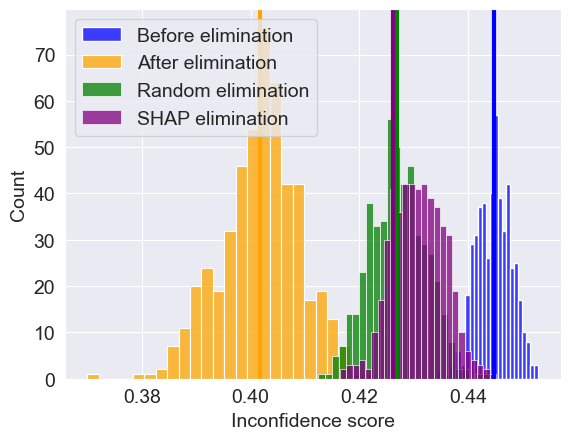

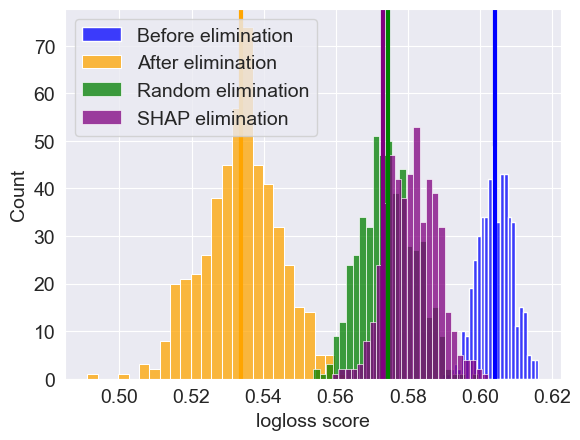

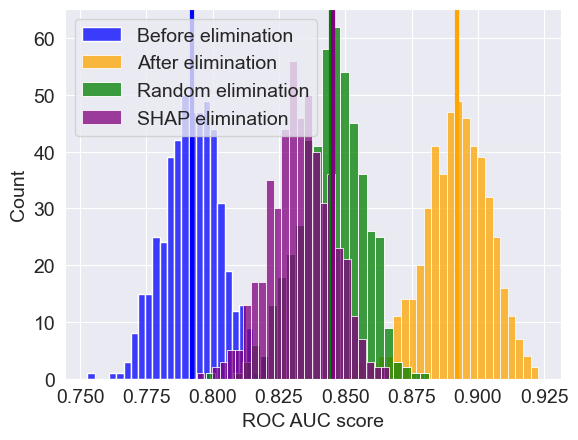

In [39]:
for k, label in enumerate(['Inconfidence score', 'logloss score', 'ROC AUC score']):
    plt.figure()
    plot_scores(metrics_before[k], metrics_after[k], metrics_r[k], metrics_s[k], label)

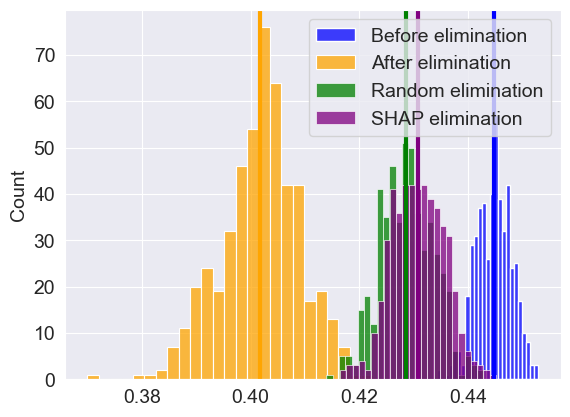

In [55]:
sns.histplot(metrics_before[0], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[0], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[0], label="Random elimination", bins=25, color="green")
sns.histplot(metrics_s[0], label="SHAP elimination", bins=25, color="purple")
plt.axvline(x=np.mean(metrics_before[0]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[0]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[0]), color="green", linewidth=3)
plt.axvline(x=np.mean(metrics_s[0]), color="purple", linewidth=3)
plt.legend()

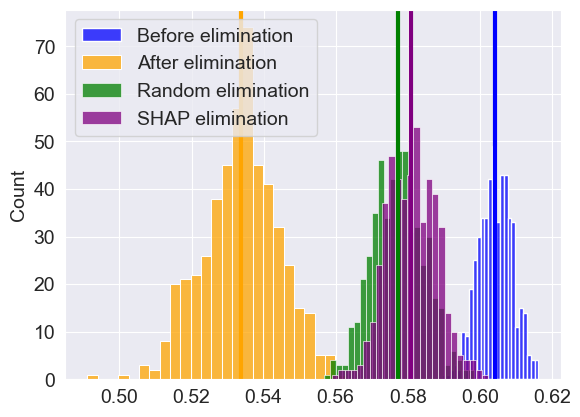

In [56]:
sns.histplot(metrics_before[1], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[1], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[1], label="Random elimination", bins=25, color="green")
sns.histplot(metrics_s[1], label="SHAP elimination", bins=25, color="purple")
plt.axvline(x=np.mean(metrics_before[1]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[1]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[1]), color="green", linewidth=3)
plt.axvline(x=np.mean(metrics_s[1]), color="purple", linewidth=3)
plt.legend()

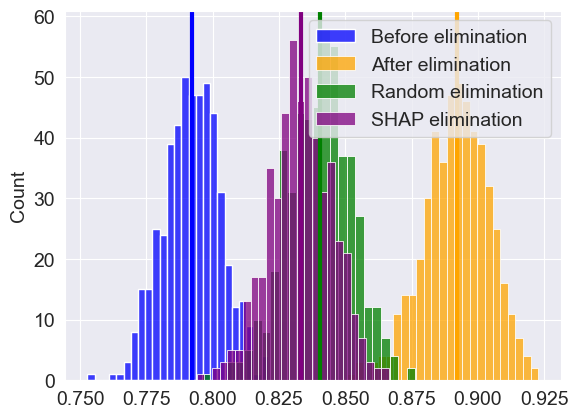

In [57]:
sns.histplot(metrics_before[2], label="Before elimination", bins=25, color="blue")
sns.histplot(metrics_after[2], label="After elimination", bins=25, color="orange")
sns.histplot(metrics_r[2], label="Random elimination", bins=25, color="green")
sns.histplot(metrics_s[2], label="SHAP elimination", bins=25, color="purple")
plt.axvline(x=np.mean(metrics_before[2]), color="blue", linewidth=3)
plt.axvline(x=np.mean(metrics_after[2]), color="orange", linewidth=3)
plt.axvline(x=np.mean(metrics_r[2]), color="green", linewidth=3)
plt.axvline(x=np.mean(metrics_s[2]), color="purple", linewidth=3)
plt.legend()

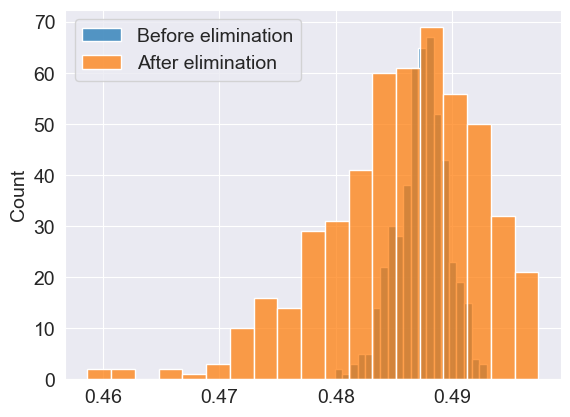

In [261]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [229]:
ttest_rel(mses_before, mses_after)

TtestResult(statistic=45.363657433495675, pvalue=3.570673536410195e-179, df=499)

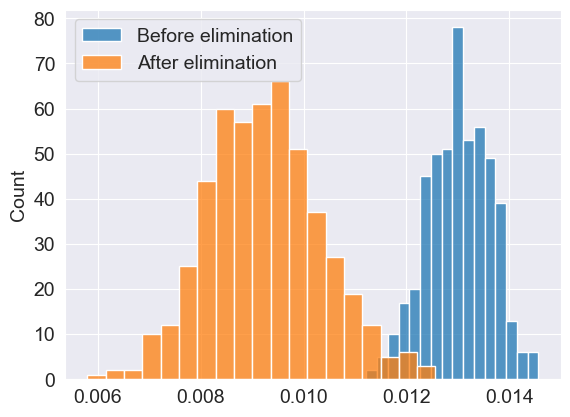

In [81]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [37]:
ttest_rel(mses_before, mses_after)

Ttest_relResult(statistic=3.5513027688261474, pvalue=0.0005886470203057337)

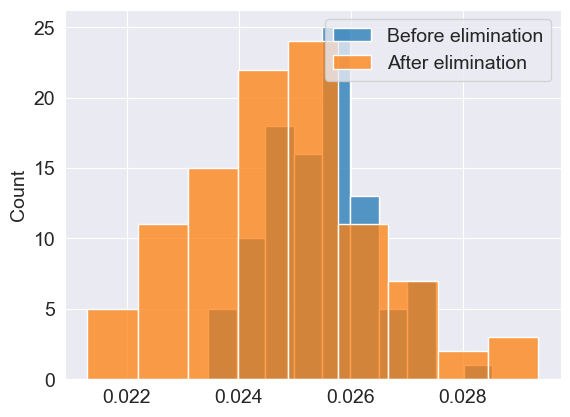

In [39]:
sns.histplot(mses_before, label="Before elimination")
sns.histplot(mses_after, label="After elimination")
plt.legend()

In [40]:
ttest_rel(mses_before, mses_after)

Ttest_relResult(statistic=4.5674716964522615, pvalue=1.4238634976675129e-05)

In [41]:
def extract_categories(data):
    return [f"{feat}_{int(k)}" for feat in data.columns for k in
            sorted(data[feat].unique())]
categories = extract_categories(disc_data)
encoder = OneHotEncoder(sparse=False)
disc_data_onehot = pd.DataFrame(encoder.fit_transform(X=disc_data), columns=categories, dtype='uint8')

In [42]:
disc_data_onehot

,Tsurf_mean_0,Tsurf_mean_1,Tsurf_mean_2,Water_mean_0,Water_mean_1,Water_mean_2,Speed_mean_0,Speed_mean_1,Speed_mean_2,totalSnow_cm_0,...,humidity_2,precipMM_0,precipMM_1,precipMM_2,pressure_0,pressure_1,pressure_2,sq_error_0,sq_error_1,sq_error_2
0,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
1,0,0,1,0,1,0,1,0,0,0,...,1,1,0,0,1,0,0,0,1,0
2,0,1,0,1,0,0,0,1,0,0,...,1,0,1,0,0,0,1,1,0,0
3,0,0,1,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0
4,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,1,0,0,1,0,0,1,...,0,1,0,0,0,0,1,1,0,0
996,0,1,0,1,0,0,0,0,1,1,...,0,1,0,0,0,1,0,1,0,0
997,0,0,1,1,0,0,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0
998,1,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0


In [43]:
gbn = DiscreteBNGI(imagespath)

In [44]:
variables=["X1", "X2"]
#gbn.add_nodes(kresult["bn"].descriptor)
#grads = [feat+'_'+str(k) for feat in variables for k in range(n_states_map[feat])]
grads = [feat+'_'+str(k) for feat in variables for k in range(3)]
gbn.add_nodes({"types": {feat: "disc" for feat in grads}})
#gbn.set_edges(grad_edges)
gbn.add_edges(data=disc_data_onehot, scoring_function=("K2", K2Score))

KeyError: 'Tsurf_mean_0'

In [ ]:
c=gbn.plot("regression.html")

In [ ]:
disc_data_errors, pipeline_data_errors = discretize(data_errors, variables=data_errors.columns.tolist(), icat=None, icont=[0, 1])

In [ ]:
disc_data_errors

In [ ]:
kresultresid = construct_by_kmeans(data_residuals, [], scoring=("K2", K2Score))

In [ ]:
c=kresultresid["bn"].plot2(imagespath, "residuals.html")